In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
import pycuber as pc
import random
from collections import defaultdict
import functools

from scipy.spatial import distance_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as gnn
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn.pool import global_mean_pool

from classes.cube_classes import Cube3State, Cube3
from generate.generate_states import ids_to_color
from utils.random_seed import seed_worker, seed_all, init_weights
from utils.compressions import *

torch.set_default_dtype(torch.float64)

In [3]:
df = pd.read_pickle('data/processed/5_moves_dataset_single.pkl')

In [30]:
df.head()

,state,colors,class_id,distance,generator
0,<classes.cube_classes.Cube3State object at 0x0...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ...",0,1,[[U']]
1,<classes.cube_classes.Cube3State object at 0x0...,"[0, 0, 0, 0, 0, 0, 5, 5, 5, 1, 1, 1, 1, 1, 1, ...",0,1,[[R']]
2,<classes.cube_classes.Cube3State object at 0x0...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ...",0,1,[[D']]
3,<classes.cube_classes.Cube3State object at 0x0...,"[4, 4, 4, 0, 0, 0, 0, 0, 0, 5, 5, 5, 1, 1, 1, ...",0,1,[[L']]
4,<classes.cube_classes.Cube3State object at 0x0...,"[0, 0, 3, 0, 0, 3, 0, 0, 3, 2, 1, 1, 2, 1, 1, ...",0,1,[[F']]


In [4]:
def indices_to_position(indices):
    pos_array = np.array([
        [0.5, 0.5, 0], [1.5, 0.5, 0], [2.5, 0.5, 0],
        [0.5, 1.5, 0], [1.5, 1.5, 0], [2.5, 1.5, 0],
        [0.5, 2.5, 0], [1.5, 2.5, 0], [2.5, 2.5, 0],
        
        [2.5, 0.5, 3], [1.5, 0.5, 3], [0.5, 0.5, 3],
        [2.5, 1.5, 3], [1.5, 1.5, 3], [0.5, 1.5, 3],
        [2.5, 2.5, 3], [1.5, 2.5, 3], [0.5, 2.5, 3],
        
        [2.5, 0, 2.5], [2.5, 0, 1.5], [2.5, 0, 0.5],
        [1.5, 0, 2.5], [1.5, 0, 1.5], [1.5, 0, 0.5],
        [0.5, 0, 2.5], [0.5, 0, 1.5], [0.5, 0, 0.5],
        
        [0.5, 3, 2.5], [0.5, 3, 1.5], [0.5, 3, 0.5],
        [1.5, 3, 2.5], [1.5, 3, 1.5], [1.5, 3, 0.5],
        [2.5, 3, 2.5], [2.5, 3, 1.5], [2.5, 3, 0.5],
        
        [3, 2.5, 2.5], [3, 2.5, 1.5], [3, 2.5, 0.5],
        [3, 1.5, 2.5], [3, 1.5, 1.5], [3, 1.5, 0.5],
        [3, 0.5, 2.5], [3, 0.5, 1.5], [3, 0.5, 0.5],
        
        [0, 0.5, 2.5], [0, 0.5, 1.5], [0, 0.5, 0.5],
        [0, 1.5, 2.5], [0, 1.5, 1.5], [0, 1.5, 0.5],
        [0, 2.5, 2.5], [0, 2.5, 1.5], [0, 2.5, 0.5],
    ])
    return pos_array[np.array(indices)]

## CompleteSubgraphsNet

In [76]:
@functools.lru_cache
def calc_distances(filtered_indices):
    vertices = indices_to_position(filtered_indices)
    dist_mat = distance_matrix(vertices, vertices)
    dist_mat = np.rint(dist_mat*10e4).astype(int)
    return dist_mat

In [108]:
def create_complete_graph_data_obj(colors, distance_from_goal, node_features_size=9, verbose=False, aggregate=False, for_hashing=False):
    indices = np.arange(54)
    colors = np.array(colors)
    node_features = np.zeros((54, node_features_size), dtype=int)
    edge_index = []
    edge_attr = []
    curr_idx = 0
    for color in range(6):
        filtered_indices = indices[colors == color]
        dist_mat = calc_distances(tuple(filtered_indices))
        node_features[filtered_indices] = dist_mat
        for i, node_i in enumerate(filtered_indices):
            for j, node_j in enumerate(filtered_indices):
#                 if i == j:
#                     continue
                edge_index.append([node_i, node_j])
                edge_attr.append(dist_mat[i,j])
        curr_idx += len(filtered_indices)
    y = distance_from_goal
    node_features = np.sort(node_features, axis=1)
    data = Data(x=torch.tensor(node_features, dtype=int), edge_index=torch.tensor(edge_index).T.long() , edge_attr=torch.tensor(edge_attr, dtype=int).unsqueeze(1), y=torch.Tensor([y]))
    return data

In [109]:
data_list_complete_graph = []
for i, row in tqdm(df.iterrows()):
    data_list_complete_graph.append(create_complete_graph_data_obj(row['colors'], row['distance']))

105045it [18:36, 94.08it/s] 


## Network

In [114]:
class GCNNet(torch.nn.Module):
    def __init__(self, hidden_channels, node_features_size=9):
        super(GCNNet, self).__init__()
        self.conv1 = gnn.SimpleConv()
#         self.conv1 = gnn.GCNConv(node_features_size, hidden_channels)
        self.lin = nn.Linear(hidden_channels, 1)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = self.conv1(x, edge_index, edge_attr)
#         x = torch.sort(torch.sum(x, dim=1))
        x = global_mean_pool(x, data.batch if data.batch is not None else torch.zeros((data.x.size(0)), dtype=torch.int64))
        x = self.lin(x)
        return x

In [117]:
netCompGraph = GCNNet(9)

In [118]:
print(netCompGraph(data_list_complete_graph[0]))

tensor([[-2.2096e+11]], grad_fn=<AddmmBackward0>)


In [119]:
netCompGraph(data_list_complete_graph[1])

tensor([[-2.2096e+11]], grad_fn=<AddmmBackward0>)

## Training

In [120]:
loader_compGraph = DataLoader(data_list_complete_graph, batch_size=128)

In [ ]:
## Training loop
optimizer = torch.optim.Adam(netCompGraph.parameters(), lr=0.001)

for epoch in range(10):
    netCompGraph.train()
    total = 0
    total_loss = 0.0
    for i, data in tqdm(enumerate(loader_compGraph)):
        optimizer.zero_grad()
        out = netCompGraph(data)
        loss = F.mse_loss(out.squeeze(), data.y.squeeze(), reduction='sum')
        loss.backward()
        total_loss += loss.item()
        total += data.y.size(0)
        optimizer.step()
    if (epoch+1) % 1 == 0:
        print(f'Epoch {epoch+1}: train loss {total_loss/total:0.4f}')

### Activation compressions

In [127]:
networksCompGraph = create_networks(NetworkClass=GCNNet, network_args={'hidden_channels': 9}, num_of_networks=10)
distance_all_acts_complete_graph = calculate_all_dicts_from_activations(df=df, max_distance=5, input_handling_func=create_complete_graph_data_obj, networks=networksCompGraph, is_graph_nn=True)

100%|█████████████████████████████████████████████████████████████████████████| 93840/93840 [11:26:08<00:00,  2.28it/s]


In [128]:
with open('data/temp/gcn_compressions_distance5.pkl', 'wb') as f:
    pickle.dump(distance_all_acts_complete_graph, f)

In [129]:
set_intersections_activations_complete_graph = compute_set_intersections(distance_all_acts_complete_graph)

Intersection size between sets 1 AND 2: 0
Intersection size between sets 1 AND 3: 0
Intersection size between sets 1 AND 4: 0
Intersection size between sets 1 AND 5: 0
Intersection size between sets 2 AND 3: 0
Intersection size between sets 2 AND 4: 0
Intersection size between sets 2 AND 5: 0
Intersection size between sets 3 AND 4: 0
Intersection size between sets 3 AND 5: 0
Intersection size between sets 4 AND 5: 0


In [130]:
df.generator = df.generator.map(np.array)
df.head()

,state,colors,class_id,distance,generator
0,<classes.cube_classes.Cube3State object at 0x0...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ...",0,1,[[U']]
1,<classes.cube_classes.Cube3State object at 0x0...,"[0, 0, 0, 0, 0, 0, 5, 5, 5, 1, 1, 1, 1, 1, 1, ...",0,1,[[R']]
2,<classes.cube_classes.Cube3State object at 0x0...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ...",0,1,[[D']]
3,<classes.cube_classes.Cube3State object at 0x0...,"[4, 4, 4, 0, 0, 0, 0, 0, 0, 5, 5, 5, 1, 1, 1, ...",0,1,[[L']]
4,<classes.cube_classes.Cube3State object at 0x0...,"[0, 0, 3, 0, 0, 3, 0, 0, 3, 2, 1, 1, 2, 1, 1, ...",0,1,[[F']]


In [131]:
print(distance_all_acts_complete_graph[0])

defaultdict(<class 'list'>, {(7496975263885935616, -10713535020333031424, -2390982420620292096, -9626671279289139200, 6240400390123182080, 15811383647044081664, 18759735645811679232, 25303925739933175808, -22685377019406651392, -44743586002506661888): [(0, array([["U'"]], dtype='<U2')), (1, array([["R'"]], dtype='<U2')), (2, array([["D'"]], dtype='<U2')), (3, array([["L'"]], dtype='<U2')), (4, array([["F'"]], dtype='<U2')), (5, array([["B'"]], dtype='<U2')), (6, array([['U']], dtype='<U1')), (7, array([['R']], dtype='<U1')), (8, array([['D']], dtype='<U1')), (9, array([['L']], dtype='<U1')), (10, array([['F']], dtype='<U1')), (11, array([['B']], dtype='<U1'))]})


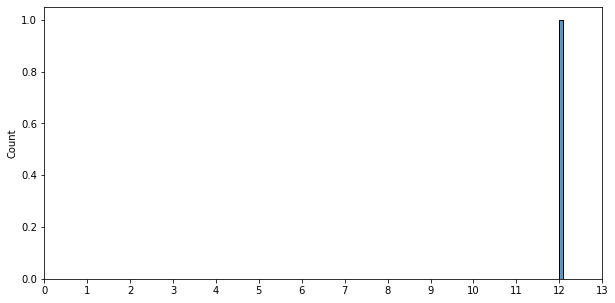

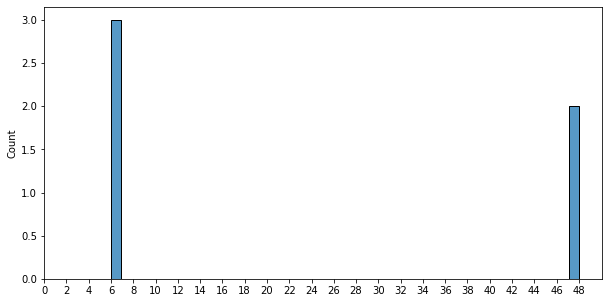

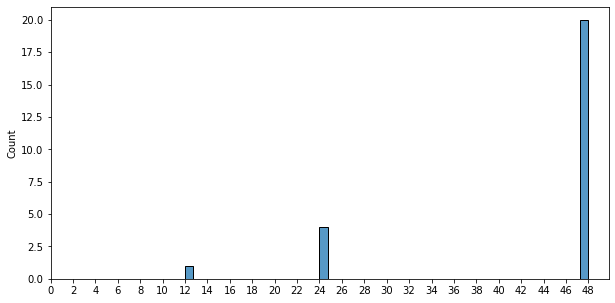

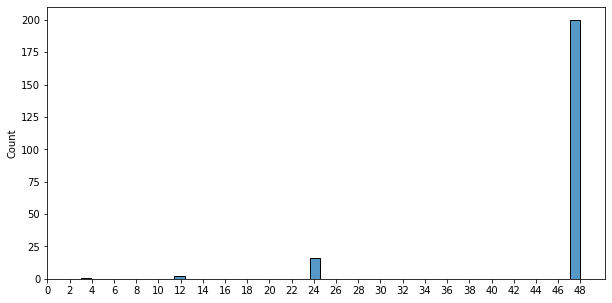

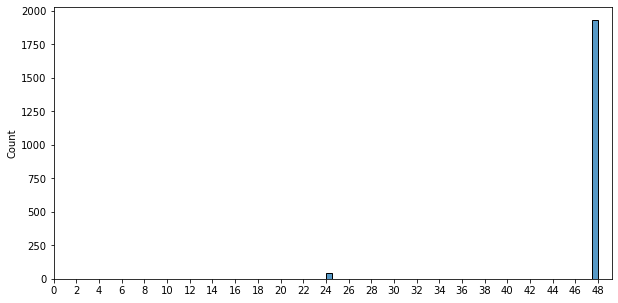

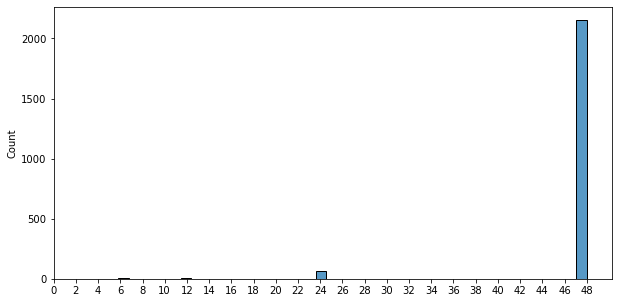

In [132]:
plot_distance_compressions(distance_all_acts_complete_graph, 'gcn_compressions/from_activations5')